In [1]:
import requests

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.nn.utils import prune
from transformers import (SamModel, SamProcessor)

from utils import show_points_on_image, show_masks_on_image

In [2]:
GPU = 3 # GPU to use
TYPE = 'L1' # L1 or random
SPARSITY = 0.3 # sparsity ratio
SEED = 0 # random seed

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

# Prune

In [3]:
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device).eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [4]:
lo = list(model.state_dict().keys())

In [5]:
with torch.no_grad():
    to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            to_prune.append((module, 'weight'))
        elif isinstance(module, torch.nn.Linear):
            to_prune.append((module, 'weight'))

    if TYPE == 'L1': ## L1 PRUNING ##
        prune.global_unstructured(to_prune, pruning_method=prune.L1Unstructured, amount=SPARSITY)
    elif TYPE == 'random': ## RANDOM PRUNING ##
        prune.global_unstructured(to_prune, pruning_method=prune.RandomUnstructured, amount=SPARSITY)

    for module, name in to_prune:
        # print(f'Pruned {name} of type {type(module)}')
        prune.remove(module, name)

In [6]:
lp = (model.state_dict().keys())

In [8]:
# Check that the set of pruned layers is the same
lp - lo

set()

In [9]:
model.save_pretrained(f'bin/GUP_{TYPE}_{int(SPARSITY*100)}/')

# Evaluate

In [10]:
# Sparse SAM
model = SamModel.from_pretrained(f'bin/GUP_{TYPE}_{int(SPARSITY*100)}/').to(device).eval()
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

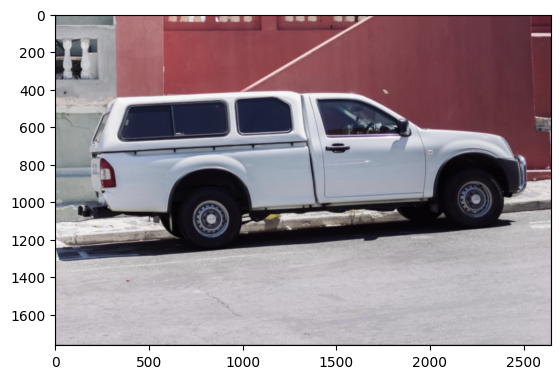

In [11]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
plt.imshow(raw_image)
plt.show()

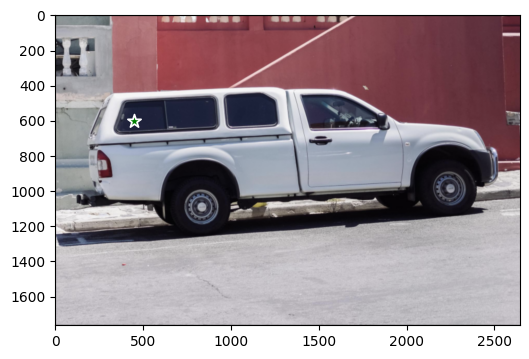

In [12]:
input_points = [[[450, 600]]]
show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

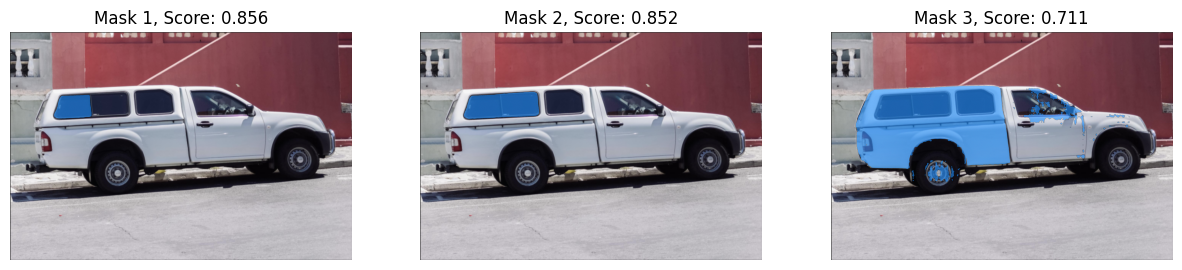

In [13]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)